<a href="https://colab.research.google.com/github/razzkoirala/devops-camp-pipeline/blob/main/LabDocument/6_Improving_the_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improving the Pipeline

Updated 5/5/2022

## Overview
In this lab, students will identify a way to improve pipeline efficiency, make the changes, and then confirm the impact of their actions.

**Estimated time:** 1 hr

## Learning Objectives

1. Monitor Jenkins "total" build times

2. Look for build time improvements

3. Make build improvements

4. Verify build is functioning properly

5. Verify "total" build time improved

# Instructions

## Identify Areas of Improvement

1. Monitor pipeline and identify the amount of time it currently takes for each stage to run

<figure>
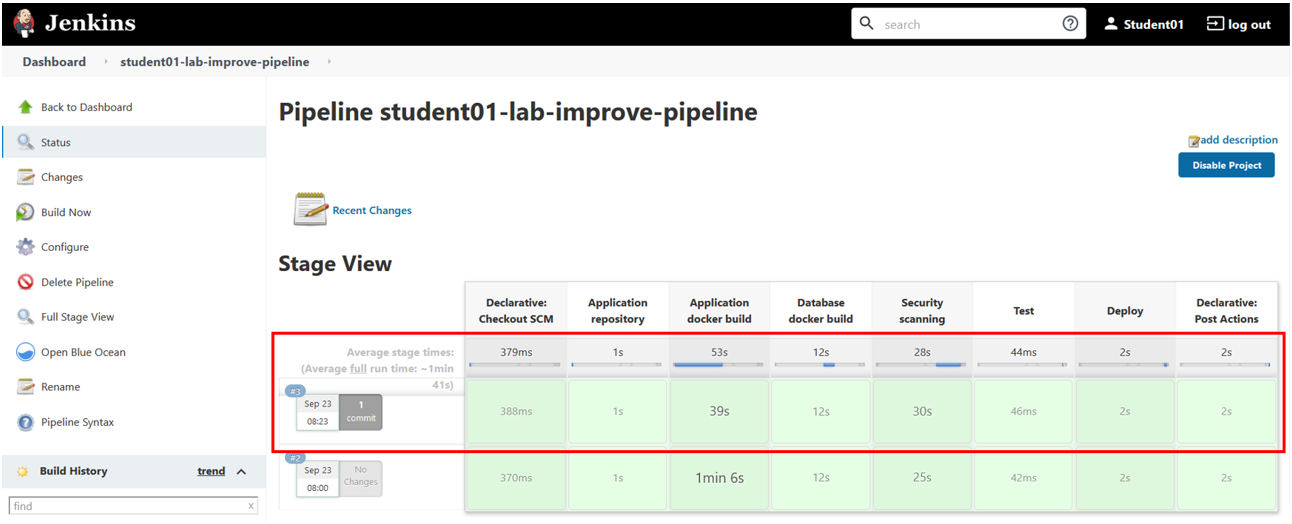
</figure>

<ul>

Build times can be improved by running the pipelines _concurrently_ instead of _sequentially_. We can also see that any changes in the application code will always trigger a build of both the application and database code/images which is unnecessary as the database code is not frequently changing. This separation will be the focus of this lab.

After separating them, changes in the database code will only trigger a build of the database.

</ul>


## Make Build Improvement


1. Create a new Jenkinsfile for the database pipeline in the `devops-camp-pipeline` folder called `devops-camp-db-jenkinsfile`. 

  > **Note:** Like the application pipeline, the database pipeline will be cloning the application repository (i.e., `afs-labs-student`). However, the pipeline will only build the database image when there are changes to `database.sql`
  
  a. In your new `devops-camp-db-jenkinsfile`, paste the following template:





In [ ]:
pipeline {
    agent {
        label 'jenkins-agent'
    }
    //TODO: add environment variables
    stages {
        //TODO: add stages to pipeline
    }
    post {
        cleanup {
            echo "Clean workspace"
            sh 'rm -rf .git ./*'
        }
    }
}

<ul>

b. Add environment variables for Harbor to the `pipeline {}` by pasting the below code snippet _after_ the `agent {}` block (and _before_ the `stages {}` block) to the `devops-camp-db-jenkinsfile`

  >**Tip:** _Replace_ `<YOUR HARBOR PROJECT NAME>` to match your Harbor project name.

</ul>

In [ ]:
environment {
        PIPELINE_HASH = sh(script: 'git rev-parse --short HEAD', returnStdout: true).trim()
        HARBOR_REGISTRY = 'harbor.dev.afsmtddso.com'
        HARBOR_PROJECT = '<YOUR HARBOR PROJECT NAME>'
        DB_IMAGE_NAME = 'db'
    }

<ul>

c.	Add a stage to clone the application repository _inside_ the `stages {}` block.

  <ul>

  i. _Replace_ `<YOUR AFS-LABS-STUDENT REPO URL>` with your GitHub application repository URL.

  ii. In the snippet below, we modify the script for the environmental variable `COMMIT_HASH` to track any changes in the `database.sql` file and grab its commit hash.

  </ul>
</ul>

In [ ]:
stage('Application repository') {
            steps {
                echo "Cloning application repository"
                sh 'git clone <YOUR AFS-LABS-STUDENT REPO URL>'
                dir('afs-labs-student') {
                    script {
                        env.COMMIT_HASH = sh(script: 'git log --format=format:%h -1 --follow database/database.sql', returnStdout: true).trim()
                    }
                }
            }
        }

<ul>

> **Note:** `COMMIT_HASH` and `PIPELINE_HASH` will be used to uniquely "tag" the database Docker image.

</ul>




2.	Now we will create a Python script called `check_harbor_db.py`. The script will compare the `database.sql` commit hash and Harbor database image tag. 

  a. In your terminal, navigate to the `devops-camp-pipeline` folder

  b.	Download the `check_harbor_db.py` script by running the following command: 

In [ ]:
curl -O 'https://raw.githubusercontent.com/khaledAFS/sample-files/main/post_improving_pipeline_lab/check_harbor_db.py'

<ul>

 c.	The `check_harbor_db.py` script will return a true/false value representing if there have been any changes made to `database.sql`. The return value will be used to determine whether or not to build the database image.  If no changes have been made, we can continue using a previous build.

 > **Note:** Please take the time to read through the script and understand how this comparison is made.

</ul>

3.	In your `devops-camp-db-jenkinsfile`, paste the following code snippet to the `stage('Application repository') {}`, _after_ the `dir('afs-labs-student') {}` block to utilize the `check_harbor_db.py` script.

 > **Note:** We’re adding an environment variable, `BUILD_DB`, and assigning it to execute the `check_harbor_db.py` script and store either true or false.


In [ ]:
withCredentials([usernamePassword(credentialsId: '<YOUR CREDENTIAL ID NAME>', usernameVariable: 'USERNAME', passwordVariable: 'PASSWORD')]) {
                    script {
                        env.BUILD_DB = sh(script: 'python check_harbor_db.py -h $COMMIT_HASH -i $DB_IMAGE_NAME -r $HARBOR_REGISTRY -p $HARBOR_PROJECT -c ${USERNAME}:${PASSWORD}', returnStdout: true).trim()
                    }
                }

<ul>

> **Tip:** _Replace_ the `credentialsID` value with the ID of the credentials you created in Jenkins (e.g., `<first initial + lastname>-harbor-auth`). Do **not** update the `USERNAME` and `PASSWORD` values.

a.	Add the following code snippet _after_ the `stage('Application repository') {}` block.

> **Note:** Our new environment variable `BUILD_DB` will be used in the `stage('DB changes: true') {}`block. When there are changes to `database.sql`, `BUILD_DB` will be set to `true`. Then the stages to build, scan, and deploy the database will execute. If `BUILD_DB` is set to `false`, the pipeline will skip this stage.

<ul>

In [ ]:
stage('DB changes: true') {
           when {
              environment name: 'BUILD_DB', value: 'true'
           }
           stages {
              stage('Database docker build') {
                  steps {
                      echo "Building database image"
                      //TODO: build docker image & push to Harbor
                  }
                  post {
                      //TODO: clean local docker images
                  }
              }
              stage('Deploy') {
                  steps {
                      echo "Deployment stage"
                      //TODO: deploy database
                  }
              }
           }
        }

<ul>

> **Explanation:**
>
> The `stage('DB changes: true') {}` is a conditional stage (i.e., the `when {}` block) that contains a `stages {}` block. Think of this as a nested concept, so within the stages there will be multiple `stage {}` blocks.

</ul>

<ul>

b. Add the following code snippet to the `stage('Database docker build') {}`, _inside_ the `steps {}` block to build the database image:

</ul>

In [ ]:
withCredentials([usernameColonPassword(credentialsId: '<YOUR CREDENTIAL ID NAME>', variable: 'HARBOR-AUTH')]) {
                          script {
                              sh 'docker build -t $DB_IMAGE_NAME-$COMMIT_HASH -f ./db/Dockerfile ./afs-labs-student'
                              docker.withRegistry('https://$HARBOR_REGISTRY', '<YOUR CREDENTIAL ID NAME>') {
                                  sh 'docker tag $DB_IMAGE_NAME-$COMMIT_HASH $HARBOR_REGISTRY/$HARBOR_PROJECT/$DB_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                                  sh 'docker push $HARBOR_REGISTRY/$HARBOR_PROJECT/$DB_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                              }
                          }
                      }

<ul>

> **Tip:** _Replace_ both occurences of `<YOUR CREDENTIAL ID NAME>` to match your Harbor credential ID name (i.e., `<first initial + last name>-harbor-auth`).

</ul>


<ul>

c. Add the following code to the `stage('Database docker build') {}`, _inside_ the `post {}` block to clean the Docker images built:

</ul>

In [ ]:
always {
                          echo "Clean local $DB_IMAGE_NAME image"
                          script {
                              try {
                                  sh 'docker rmi $DB_IMAGE_NAME-$COMMIT_HASH:latest'
                                  sh 'docker rmi $HARBOR_REGISTRY/$HARBOR_PROJECT/$DB_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'
                              } catch (err) {
                                  echo err.getMessage()
                              }
                          }
                      }

<ul>

d. Add the following line to the `stage('Deploy') {}`, _inside_ the `steps {}` block to deploy the containers to EKS:

</ul>

In [ ]:
sh 'kubectl -n <YOUR EKS NAMESPACE> set image deployment/db-deployment db-deployment=$HARBOR_REGISTRY/$HARBOR_PROJECT/$DB_IMAGE_NAME:$COMMIT_HASH-$PIPELINE_HASH'

<ul>

> **Tip:** Make sure you replace `<YOUR EKS NAMESPACE>` with your personal EKS namespace (e.g., first initial + last name)

e. Save your changes

</ul>

4. Clean up your `devops-camp-jenkinsfile` (i.e., the original one) by removing everything associated with the database, including environment variables, the DB build stage, the DB deployment stage, etc.

5. In the terminal, make sure you're in the right directory before adding, committing, and pushing your files to GitHub like you've done previously

6. **Navigate to the Jenkins website and verify that your pipeline builds successfully; if not, debug and resolve the issue(s) before moving on**

7. Create a new pipeline for building your database by following the instructions below:

  a. On the Jenkins website, under the "Dashboard", click on "New Item" on the left 

<figure>
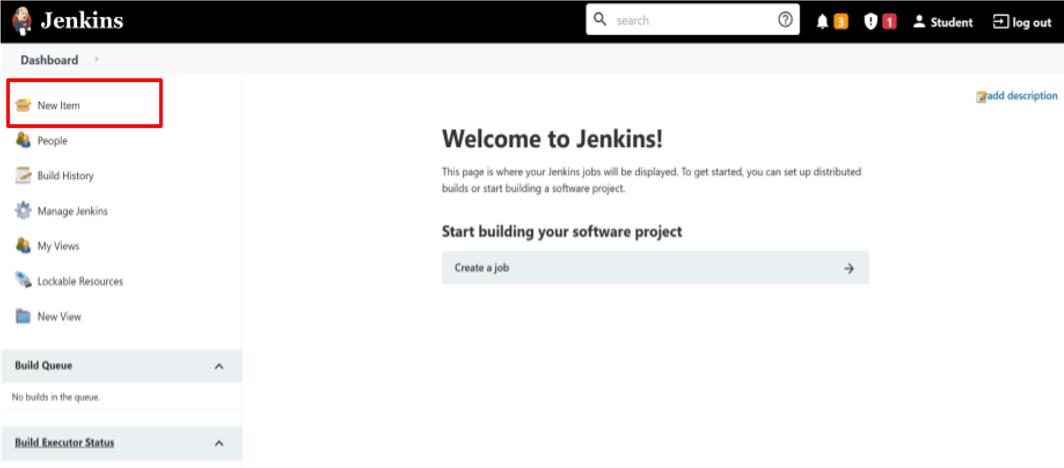
</figure>

<ul>

  b. Name the pipeline `<YOUR FIRST INITIAL + LAST NAME>-db-pipeline`, click "Pipeline," then click "OK" at the bottom to create the pipeline.

  c. On the next page, if "Enable project-based security" isn't checked already, click on the checkbox and ensure that the options match those of the image below:

  </ul>

<figure>
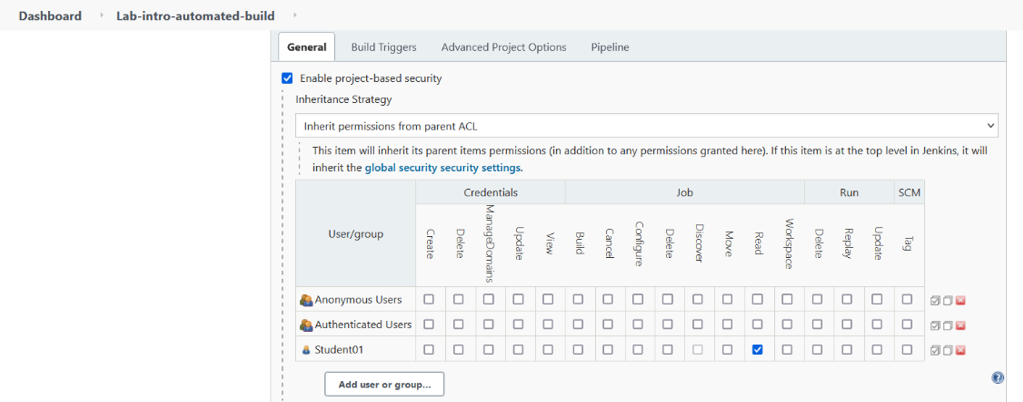
</figure>

<ul>

  d. A few options underneath, check "GitHub project" and paste the URL (including the .git portion) of your `devops-camp-pipeline` repository.

</ul>

<figure>
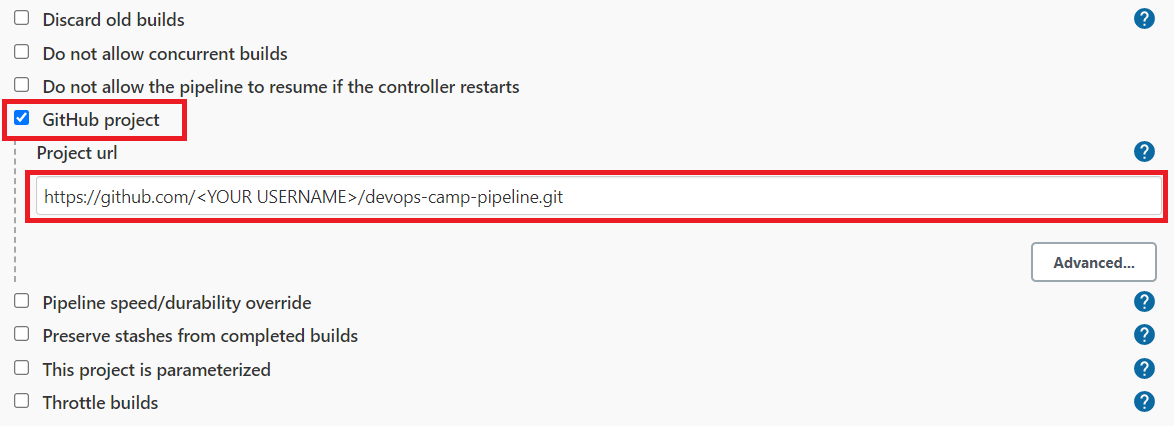
</figure>

<ul>

  e. Scroll down to the "Build Triggers" subsection and check "GitHub hook trigger for GITScm polling"

</ul>

<figure>
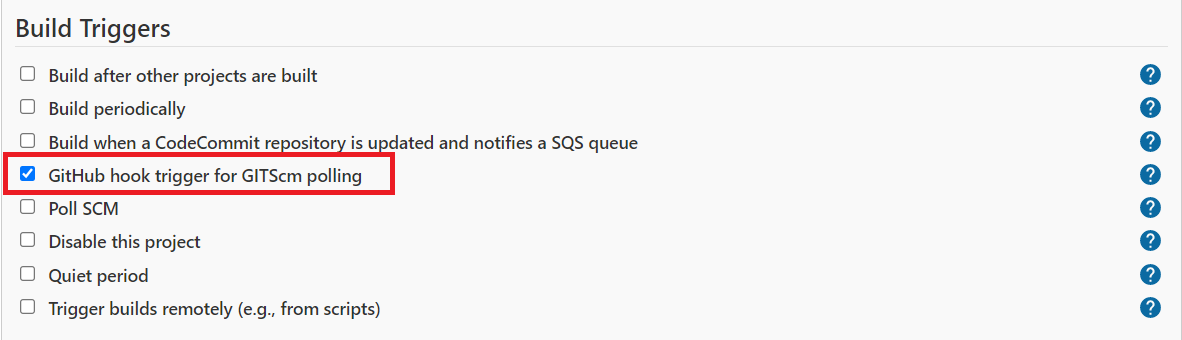
</figure>

<ul>

  f. Select the "Pipeline" tab at the top. Under "Definition," click "Pipeline script" to open the dropdown menu; select "Pipeline script from SCM"

  g. In the SCM dropdown menu, select "Git"

  h. In "Repositories" section, paste your `devops-camp-pipeline` repository URL (including the .git portion)

</ul>

<figure>
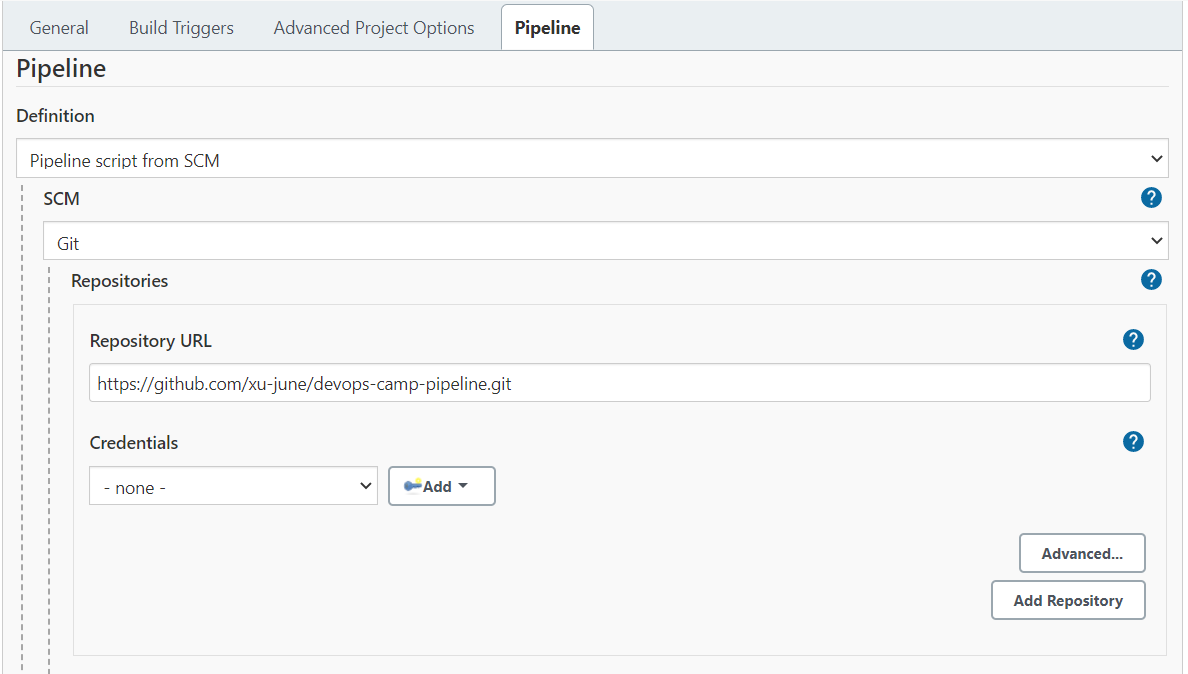
</figure>

<ul>

  i. In "Branches to build," make sure you put your main branch; this could be either `main` or `master`

  j. Replace the default "Script Path" with your updated Jenkinsfile name, `devops-camp-db-jenkinsfile`

  k. Save your new pipeline by clicking the "Save" button at the bottom

</ul>

<figure>
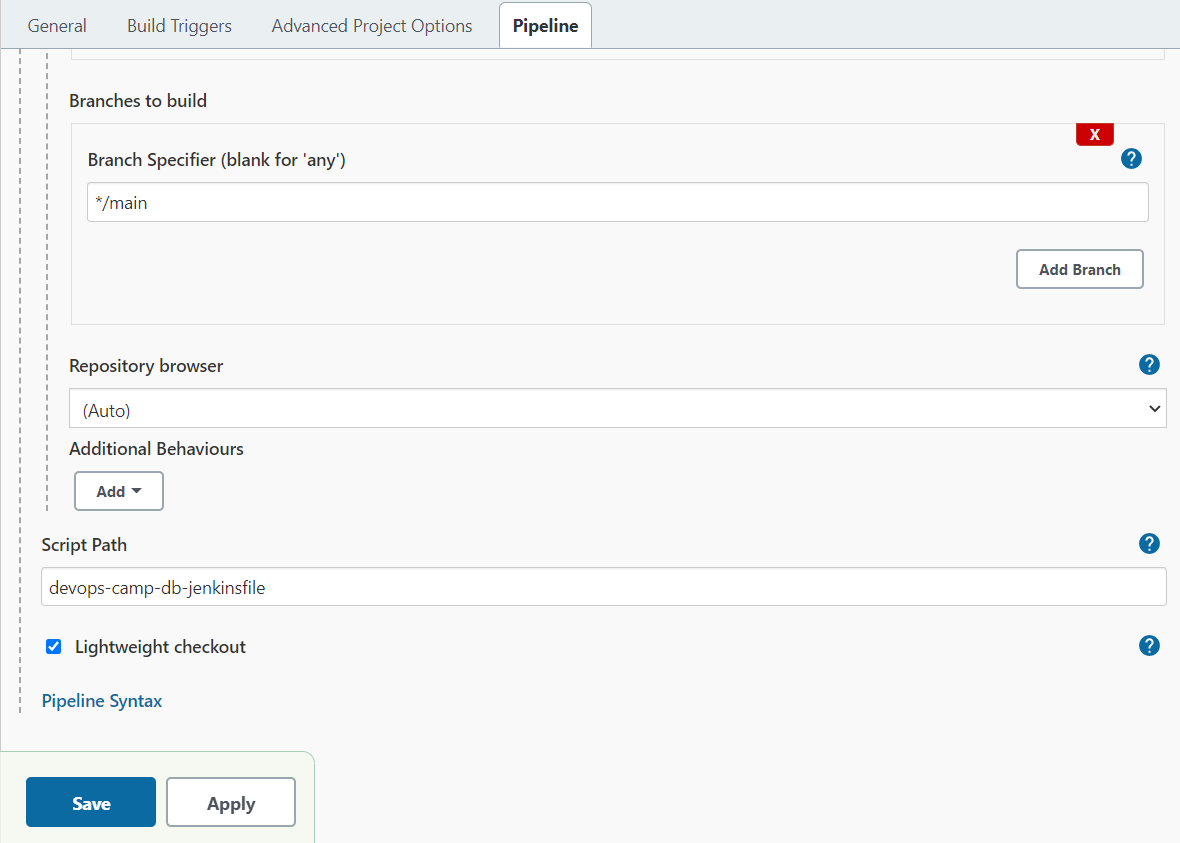
</figure>

8. In GitHub, create a second webhook for your `afs-labs-student` repository by following the instructions below:

  a. Navigate to your GitHub `afs-labs-student` repository

  b. Under Settings → Webhooks, click on “Add webhook”

  c. In the “Payload URL” box, paste in the following URL filled in with your information:
```
https://<JENKINS USERNAME>:<API TOKEN>@jenkins.dev.afsmtddso.com/job/<JENKINS PIPELINE NAME>/build/
```

  > **Tip:** Your API token is the token that you created and saved in one of the first labs. Your Jenkins pipeline name should be `<YOUR FIRST INITIAL + LAST NAME>-db-pipeline`

  c.	Make sure the “Content type” is application/json

  d.	Click on “Add webhook” to create the webhook

  > **Note:** If done correctly, adding the webhook will trigger a build in db pipeline.

9. In VSCode, find and open `database.sql` in your `afs-labs-student/database` folder

10.	Add a comment to the first line (comments are preceded by `--`)

11.	In the terminal, make sure you're in the `afs-labs-student` directory before commiting and pushing the updated code

  a.	Check to make sure that your new database pipeline automatically builds  when changes are made (and pushed) in `database.sql`

12. **Ensure that both of your pipelines build successfully (i.e., all the stages are green)**

13. **Navigate to your website and ensure that it displays all features before moving on**

## Verify Improvements

1.	Make a change to your application code, in any file besides `database.sql`, and ensure that the application pipeline builds after the change is pushed to your GitHub repository.
  
  a.	Ensure that the database pipeline doesn't reach the database build stage; it should look like the one shown in the image below:

<figure>
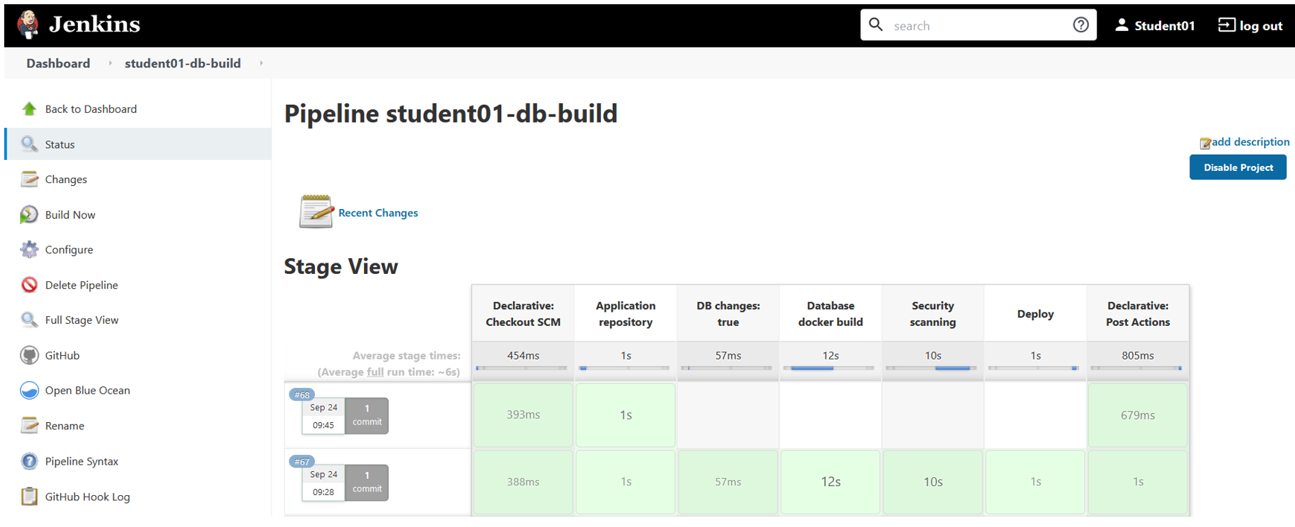
</figure>

2.	Confirm that overall build time has been reduced

## You're done if...

1. Making a change to a file other than `database.sql` successfully builds both your application and database pipelines, but the middle stages of the database pipeline are skipped

  a. A successful build means seeing all green blocks under each stage, except for those that were skipped in the database pipeline (they should be grey/white).

2. Making a change to `database.sql` successfully builds both your application and database pipelines without skipping any stages

  a. Again, you're looking for green blocks underneath each stage; this time, none of them should be grey/white.

3. Both your pods are running and there are no errors in your logs

4. Your website displays all the expected features

# Appendix

Sample files of what your files should look like after this lab are available at:  https://github.com/khaledAFS/sample-files/tree/main/post_improving_pipeline_lab